In [1]:
import numpy as np
import pickle   
import matplotlib.pyplot as plt
import scipy
import yaml
import tensorflow as tf

import os, sys
sys.path.append('../')

from src.eval.evaluate import Evaluator
from src.utils import ParseArgs, get_configs, load_data, init_model


In [2]:
with open('../trained_models/PlaNet_10ksample_physics_informed/history.pkl', 'rb') as f:
    history_10k_PI = pickle.load(f)
with open('../trained_models/PlaNet_10ksample_no_physics_informed/history.pkl', 'rb') as f:
    history_10k_noPI = pickle.load(f)
with open('../trained_models/PlaNet_70ksample_physics_informed/history.pkl', 'rb') as f:
    history_70k_PI = pickle.load(f)

In [3]:
def running_mean(x, N):
    # cumsum = np.cumsum(np.insert(x, 0, 0)) 
    # return (cumsum[N:] - cumsum[:-N]) / float(N)
    return np.convolve(x, np.ones(N)/N, mode='same')

In [4]:
print(int(10000/64*2800), int(70000/64*400), int(70000/512*3500))

437500 437500 478515


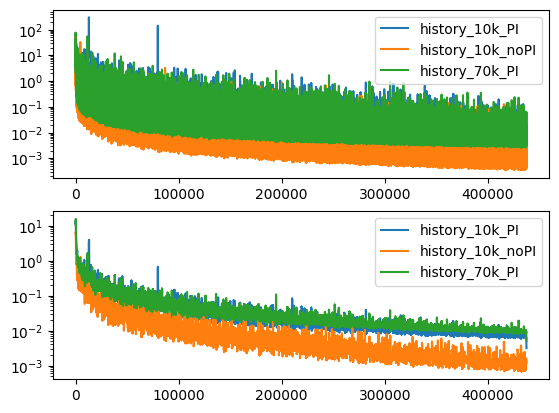

In [5]:

n_steps = int(10000/64*2800)

fig, ax = plt.subplots(2)
#
ax[0].plot(np.linspace(0, n_steps, len(history_10k_PI['loss_iter'])), history_10k_PI['loss_iter'], label='history_10k_PI')
ax[0].plot(np.linspace(0, n_steps, len(history_10k_noPI['loss_iter'])), history_10k_noPI['loss_iter'], label='history_10k_noPI')
ax[0].plot(np.linspace(0, n_steps, len(history_70k_PI['loss_iter'])), history_70k_PI['loss_iter'], label='history_70k_PI')
ax[0].set_yscale('log')
ax[0].legend()
#
ax[1].plot(np.linspace(0, n_steps, len(history_10k_PI['loss_iter'])), running_mean(history_10k_PI['loss_iter'],n_steps//1000), label='history_10k_PI')
ax[1].plot(np.linspace(0, n_steps, len(history_10k_noPI['loss_iter'])), running_mean(history_10k_noPI['loss_iter'],n_steps//1000), label='history_10k_noPI')
ax[1].plot(np.linspace(0, n_steps, len(history_70k_PI['loss_iter'])), running_mean(history_70k_PI['loss_iter'],n_steps//1000), label='history_70k_PI')
ax[1].set_yscale('log')
ax[1].legend()

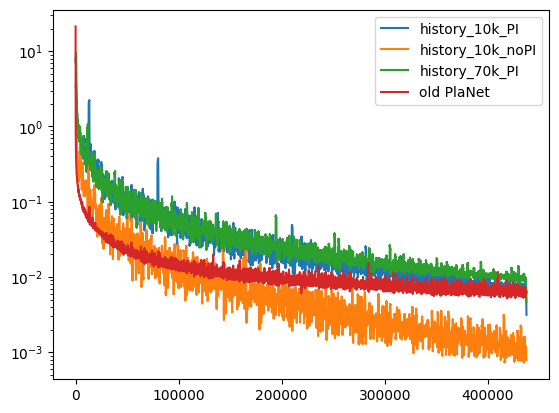

In [6]:
mat_history_kin_p = scipy.io.loadmat(r'../data/from_old_run/history_PlaNet_Equil_kin_65588sample')['history']
mat_history_kin_p_2 = scipy.io.loadmat(r'../data/from_old_run/history_PlaNet_Equil_kin_65588_2')['history']

mat_history_kin_p = np.column_stack((mat_history_kin_p,mat_history_kin_p_2[:,1:])).ravel()
running_mean_window = n_steps//500
fig, ax = plt.subplots(1)
#
ax.plot(np.linspace(0, n_steps, len(history_10k_PI['loss_iter'])), running_mean(history_10k_PI['loss_iter'],running_mean_window), label='history_10k_PI')
ax.plot(np.linspace(0, n_steps, len(history_10k_noPI['loss_iter'])), running_mean(history_10k_noPI['loss_iter'],running_mean_window), label='history_10k_noPI')
ax.plot(np.linspace(0, n_steps, len(history_70k_PI['loss_iter'])), running_mean(history_70k_PI['loss_iter'],running_mean_window), label='history_70k_PI')
ax.plot(np.linspace(0, n_steps, mat_history_kin_p.shape[0]), mat_history_kin_p, label='old PlaNet')
ax.set_yscale('log')
ax.legend()


In [8]:
def load_result(path):
    with open(path + 'configs.yaml', 'r') as f:
        config = yaml.safe_load(f)
    with open(path + '/history.pkl', 'rb') as f:
        history = pickle.load(f)
    
    for k,v in config['data']['path'].items():
        config['data']['path'][k] = '.' + v

    train_ds, test_ds = load_data(config)
    model = init_model(test_ds)

    model.load_weights(path + 'trained_model.keras', skip_mismatch=False)

    return config, history, model, train_ds, test_ds

paths = [
    '../trained_models/PlaNet_10ksample_no_physics_informed/',
    '../trained_models/PlaNet_10ksample_physics_informed/',
    '../trained_models/PlaNet_70ksample_physics_informed/'
]
mse_flux = []
for path in paths:
    config, history, model, train_ds, test_ds = load_result(path)

    evaluator = Evaluator(
        model=model,
        config=config,
        test_ds = test_ds
    )
    evaluator.run()
    mse_flux.append(evaluator.mse_flux)

100%|██████████| 256/256 [00:07<00:00, 35.33it/s]


0.0013535223 0.0062273815
0.0013060503 0.004366393
0.0017564372 0.0016114315


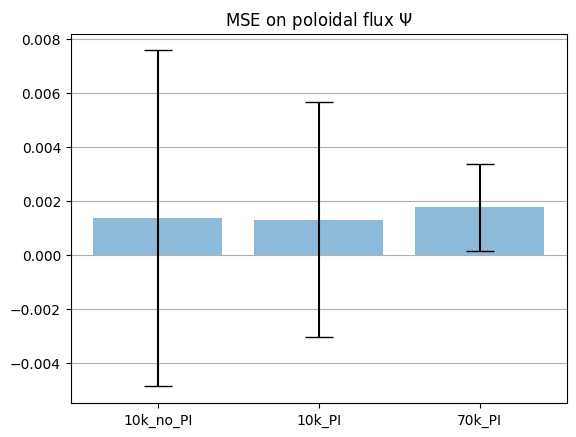

In [18]:
[print(x.mean(), x.std()) for x in mse_flux]
res = np.zeros((3,2))
for i,x in enumerate(mse_flux):
    res[i,...] = np.array([x.mean(), x.std()])

res_mean = [x.mean() for x in mse_flux]
res_std = [x.std() for x in mse_flux]

names = ['10k_no_PI', '10k_PI', '70k_PI']
x_pos = np.arange(len(names))


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, res_mean, yerr=res_std, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Coefficient of Thermal Expansion ($\degree C^{-1}$)')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_title('MSE on poloidal flux $\Psi$')
ax.yaxis.grid(True)